# Input Data: Run at the first time
> add Dataset's path to the os

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


# Import Packages

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

# Preprocessing (Pipeline)
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from scipy.stats import uniform

# Split dataset
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
# import xgboost as xgb

# Crossvalidation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Visualization
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # add complex metrics to plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Load Datasets

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

# EDA

### Features
- `person_age`: Applicant’s age in years.
- `person_income`: Annual income of the applicant in USD.
- `person_home_ownership`: Status of homeownership (Categorical).
- `person_emp_length`: Length of employment in years.
- `loan_intent`: Purpose of the loan (Categorical).
- `loan_grade`: Risk grade assigned to the loan, assessing the applicant’s creditworthiness.
- `loan_amnt`: Total loan amount **requested** by the applicant.
- `loan_int_rate`: Interest rate associated with the loan.
- `loan_status`: The **approval status** of the loan.
- `loan_percent_income`: Percentage of the applicant’s income allocated towards loan repayment.
- `cb_person_default_on_file`: Indicates if the applicant has a history of default.
- `cb_person_cred_hist_length`: Length of the applicant’s credit history in  years.

### Hypothesis
**Needs to be organized**
> 1. Purpose of the loan does **NOT** influence the loan status.
> 2. Easily available for loans at the applicant's **MOST employable age** group.
> 3. Loan grade **MAY** the characteristic Feature that has the greatest impact on the loan status.
> 4. Loan grade 연관 있는 Feature들 (`cb_person_default_on_file`, `cb_person_cred_hist_length`, `loan_percent_income`, `loan_amnt`,`...` what else?)
> 5. 이자율과 다른 Feature과의 관계? (~Loan grade?)
> 6. 

### Analysis Plan
**Needs to be organized**
- `loan_status` ~ `person_age`+`person_income`+`person_emp_length`
- `loan_int_rate` ~ `loan_grade` (+`loan_amnt`?)
- `loan_status`~`loan_amnt`
- `loan_status`~`person_income` + `loan_int_rate`


In [4]:
# Linear Modeling


# Preprocessing

In [5]:
# backup for dataset's idx
train_idx = train['id']
test_idx = test['id']

# remove its idx
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

# separate the target
y = train['loan_status']  # target
X = train.drop('loan_status', axis=1)

# Train Model

In [6]:
# set train and eval data 9:1
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=142, stratify=y)

# column types
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# ...
remove_strings = ['person_age']
numerical_cols = [item for item in numerical_cols if item not in remove_strings]

# Preprocessor Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # 수치형 컬럼에 대해 StandardScaler 적용
        # ('cat', OrdinalEncoder(), categorical_cols)  # 범주형 컬럼에 대해 OrdinalEncoder 적용 0.88
         ('cat', OneHotEncoder(drop='first'), categorical_cols)  # 범주형 컬럼에 대해 OneHotEncoder 적용
    ]
)

In [7]:
# Logistic Linear (Classification)
logistic_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(solver='liblinear') # {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
)

In [8]:
# Hyperparameter tuning (ROC-AUC)
## nomalize
param_distributions = {
    'logisticregression__C': uniform(0.001, 1000),  # uniform(0.01, 10)
    'logisticregression__penalty': ['l1', 'l2', 'elaticnet', 'none'] #  {'l1', 'l2', 'elasticnet', 'none'}
}

## Random Search
random_search = RandomizedSearchCV(
    logistic_pipeline, 
    param_distributions, 
    n_iter=1000, 
    cv=5, # cross validation folds
    random_state=42, #
    n_jobs=-1, # ram core -1: use all
    scoring='roc_auc'  # ROC-AUC를 기준으로 스코어링
)

# ## Grid Search
# grid_search = GridSearchCV(
#     logistic_pipeline,
#     param_grid=
#     {
#     'logisticregression__C': [0.01, 0.1, 1, 5, 8, 10],  # uniform(0.01, 10)
#     'logisticregression__penalty': ['l1', 'l2'] 
# },
#     cv=5,
#     scoring='roc_auc'
# )


In [9]:
# fit model
random_search.fit(X_train, y_train)
# grid_search.fit(X_train, y_train)

# get probs (Validation)
y_val_probs_rs = random_search.predict_proba(X_val)[:, 1] 
# y_val_probs_gs = grid_search.predict_proba(X_val)[:, 1]

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2435 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1285 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.d

ROC-AUC 점수: 0.9048


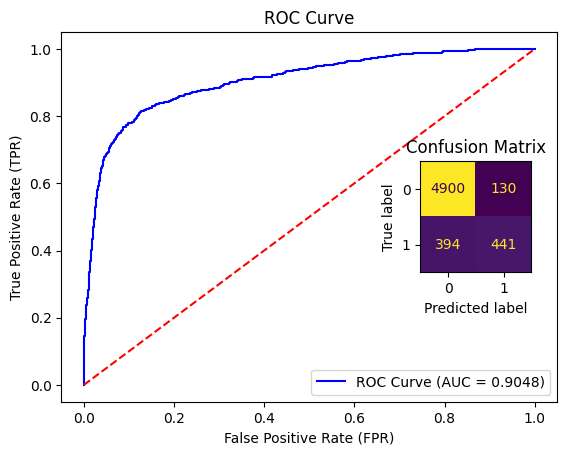

In [10]:
# ROC-AUC scores
roc_auc = roc_auc_score(y_val, y_val_probs_rs)
print(f'ROC-AUC 점수: {roc_auc:.4f}')

# ROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs_rs)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')  # 랜덤 추측선
ax.set_xlabel('False Positive Rate (FPR)')  # 위양성 비율
ax.set_ylabel('True Positive Rate (TPR)')  # 진양성 비율
ax.set_title('ROC Curve')
ax.legend(loc='lower right')
ax.grid(False)

# Predict(Validation)
y_val_preds = random_search.best_estimator_.predict(X_val)

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_val_preds)

# ROC 곡선 안에 혼동 행렬 삽입
ax_inset = inset_axes(ax, width="30%", height="30%", loc="center right")  # 위치 조정 가능
ConfusionMatrixDisplay(cm).plot(ax=ax_inset, colorbar=False)
ax_inset.grid(False)  # 혼동 행렬에 그리드 제거
ax_inset.set_title('Confusion Matrix')  # 작은 창에 제목 추가

# 그래프 보여주기
plt.show()

# 테스트 데이터 예측 및 제출 파일 저장
test = test.loc[:, categorical_cols + numerical_cols]
now = datetime.now()

In [11]:
test

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,RENT,HOMEIMPROVEMENT,F,N,69000,3.0,25000,15.76,0.36,2
1,MORTGAGE,PERSONAL,C,Y,96000,6.0,10000,12.68,0.10,4
2,RENT,VENTURE,E,Y,30000,5.0,4000,17.19,0.13,2
3,RENT,DEBTCONSOLIDATION,A,N,50000,4.0,7000,8.90,0.14,7
4,MORTGAGE,HOMEIMPROVEMENT,D,Y,102000,8.0,15000,16.32,0.15,4
...,...,...,...,...,...,...,...,...,...,...
39093,MORTGAGE,DEBTCONSOLIDATION,B,N,31200,2.0,3000,10.37,0.10,4
39094,MORTGAGE,EDUCATION,A,N,48000,6.0,7000,6.03,0.15,3
39095,MORTGAGE,PERSONAL,A,N,60000,0.0,15000,7.51,0.25,25
39096,MORTGAGE,PERSONAL,D,Y,36000,4.0,14000,15.62,0.39,4


In [12]:
submission = pd.DataFrame(test_idx)
# 테스트 데이터에 대한 예측 수행
submission['loan_status'] = np.round(random_search.best_estimator_.predict_proba(test)[:, 1], 2)
submission.to_csv(f'result_{now.strftime("%Y-%m-%d_%H-%M-%S")}.csv', index=False)

In [13]:
# pl_xgb = make_pipeline(
#     preprocessor,
#     xgb.XGBClassifier(objective='binary:logistic', missing = None)  # 로지스틱 회귀 모델
# )

# grid_search = GridSearchCV(lr_model, param_grid=LR_params, cv=5)


# random_search = RandomizedSearchCV(
#     logistic_pipeline, 
#     param_distributions, 
#     n_iter=100, 
#     cv=2, 
#     random_state=42, 
#     n_jobs=-1, 
#     scoring='roc_auc'  # ROC-AUC를 기준으로 스코어링
# )

In [14]:
# pl_xgb.fit()